In [63]:
import sys
sys.path.append('..')
from db1 import *
import pandas as pd

R = PolynomialRing(QQ, 't')
t = R.gen()

def is_paving(M):
    n = M.size()
    r = M.rank()
    return (len(M.independent_r_sets(r-1)) == binomial(n, r-1))

def q_kl(k, h):
    return kazhdan_lusztig_inverse_uniform(k, h+1) - kazhdan_lusztig_inverse_uniform(k-1, h)

def kl_inverse_fast(M):
    if M.loops(): return R(0)
    k, n = M.rank(), M.size()
    if k == n or k == 0: return R(1)
    if not M.is_connected():
        ans = R(1)
        CC = M.components()
        for N in CC:
            res = M.delete(M.groundset() - N)
            ans = ans * kl_inverse_fast(res)
        return ans

    if is_paving(M):
        return kl_inverse_paving(M)
    if is_paving(M.dual()):
        return kl_inverse_copaving(M)
    """
    if n <= 8 and M.is_connected():
        for i in range(len(mat[n][k])):
            if mat[n][k][i].is_isomorphic(M):
                return ikl[n][k][i]
    """
    LF = M.lattice_of_flats()
    ans = R(0)
    for F in LF:
        if len(F) != n:
            Res = M.delete(M.groundset() - F)
            Con = M.contract(F)
            chi = characteristic_polynomial(Con)(1/t) * t**(Con.rank())
            PPP = kl_inverse_fast(Res)(t) * (-1)**(Res.rank())
            ans = ans + chi * PPP
    assert (t**k * ans(1/t)).numerator() == -ans(t)
    ans = ans.numerator() * (-1)**(k+1)
    return ans.truncate((k+1)//2)

def kazhdan_lusztig_inverse_uniform(k, n):
    if k == n:
        return R(1)
    d = k
    m = n - d
    ans = 0
    for j in range((d-1)//2 + 1):
        ans = ans + m * (d-2*j)/((m+j) * (m+d-j)) * binomial(d, j) * t**j
    return ans * binomial(m+d, d)

def kl_inverse_paving(M):
    assert is_paving(M)
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.hyperplanes():
        h = len(H)
        if h >= k:
            ans = ans - q_kl(k, h)
    return ans

def kl_inverse_copaving(M):
    assert is_paving(M.dual())
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.dual().hyperplanes():
        h = len(H)
        if h >= n-k:
            ans = ans - kli_vtilde_dual(n-k, h, n) + kazhdan_lusztig_inverse_uniform(h-n+k+1, h) * kazhdan_lusztig_inverse_uniform(n-h-1, n-h)
    return ans

def kli_vtilde_dual(k, h, n):
    return helper1(n-k, h, n)

def helper1(k, h, n):
    c = n - h
    ans1 = kazhdan_lusztig_inverse_uniform(k, n)
    ans2 = helper2(c, k, n)
    ans3 = kazhdan_lusztig_inverse_uniform(k-c+1, h) * kazhdan_lusztig_inverse_uniform(c-1, c)
    return ans1 - ans2 + ans3

def helper2(c, k, n):
    h = n - c
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * (-1)**(c-1+j) * kazhdan_lusztig_inverse_uniform(c-1, c) * t**(k-c-j+1) * chuly(k-c-j+1, n-c-j)(1/t)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(i+j) * t**(k-i-j) * helper4(c, k, n, i, j)(1/t)
    ans = ans.numerator().truncate((k-1)//2 + 1)
    if ans[0] < 0:
        ans = -ans
    return ans

def helper3(c, k, n):
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * kazhdan_lusztig_uniform_matroid(c-1, c) * (-1)**(k-c-j+1) * kazhdan_lusztig_inverse_uniform(k-c-j+1, n-c-j)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(k-i-j) * helper2(c-i, k-i-j, n-i-j)
    return -ans

def helper4(c, k, n, i, j):
    ans = 0
    for l in range(c-i-1):
        ans = ans + (-1)**l * (t-1)**(max(n-i-j-l-1, 0))
    for u in range(n-k-1):
        ans = doit_once(ans)
    return ans

def chuly(a, b):
    ans = (t-1)**b
    for i in range(b-a):
        ans = doit_once(ans)
    return ans

def doit_once(p):
    p = p // t**2
    p = p * t
    p = p - p(1)
    return p

def lorenzo(k, h, n):
    c = n - h
    ans1 = kazhdan_lusztig_uniform_matroid(k, n) + kazhdan_lusztig_uniform_matroid(k-c+1, h) * kazhdan_lusztig_uniform_matroid(c-1, c)
    ans2 = helper3(c, k, n)
    return ans1 - ans2

In [64]:
def kl(M):
    return M.lattice_of_flats().kazhdan_lusztig_polynomial().factor()(t)

def set_division(M, e):
    L = M.lattice_of_flats()
    divs = {'A': set(), 'B': set(), 'C': set(), 'D': set()}
    for x in L[1:]:
        if set(e).issubset(set(x)):
            if frozenset(set(x) - set(e)) in L:
                divs['A'].add(x)
            else:
                divs['D'].add(x)
        else:
            if frozenset(set(x) | set(e)) in L:
                divs['C'].add(x)
            else:
                divs['B'].add(x)
    return divs

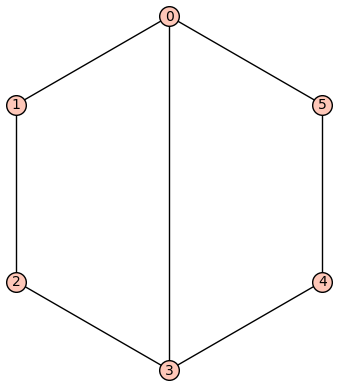

frozenset({(0, 3)})

In [65]:
#creating parallel connection of cycles
m, n = 4, 4

def parallel_connection(m, n):
    G = graphs.CycleGraph(m + n - 2)
    G.add_edge(0, m-1)
    edge_e = frozenset({(0, m - 1)})
    return G, edge_e

G, edge_e = parallel_connection(n, n)
G.show()
M = Matroid(G)

flats = M.lattice_of_flats().list()
gset = M.groundset()
labels = {element: idx for idx, element in enumerate(gset)}
relabel_flats = {flat: frozenset({labels[element] for element in flat}) for flat in flats}
edge_e

In [66]:
emptyset = frozenset()
divs = set_division(M, edge_e)
divs_deletion = {x: set(frozenset(set(y) - set(edge_e)) - {emptyset} for y in divs[x]) for x in divs}

for key, value in divs.items():
    print(f"{key}: {[relabel_flats[v] for v in value]}")

deletion_flats = M.delete(edge_e).lattice_of_flats().list()

relabel_flats_deletion = {flat: frozenset({labels[element] for element in flat}) for flat in deletion_flats}

for key, value in divs_deletion.items():
    print(f"{key}: {[relabel_flats_deletion[v] for v in value]}")

A: [frozenset({0, 3, 5}), frozenset({2, 3}), frozenset({3, 4, 5}), frozenset({0, 2, 3}), frozenset({0, 3, 6}), frozenset({0, 3}), frozenset({1, 3, 5}), frozenset({3, 6}), frozenset({3, 4, 6}), frozenset({3, 4}), frozenset({3}), frozenset({1, 2, 3}), frozenset({1, 3, 6}), frozenset({1, 3}), frozenset({2, 3, 4}), frozenset({3, 5})]
B: [frozenset({0, 4, 6}), frozenset({0, 4, 5, 6}), frozenset({0, 4, 5}), frozenset({0, 1, 2, 6}), frozenset({0, 2, 5}), frozenset({0, 4}), frozenset({0, 1, 2}), frozenset({1, 4, 5}), frozenset({1, 2, 4}), frozenset({1, 5, 6}), frozenset({0, 2, 6}), frozenset({0, 1, 2, 5}), frozenset({2, 6}), frozenset({4, 5, 6}), frozenset({1, 4, 6}), frozenset({5, 6}), frozenset({2, 4, 6}), frozenset({1, 2, 4, 5}), frozenset({1, 2, 6}), frozenset({0, 1, 6}), frozenset({2, 5}), frozenset({1, 4, 5, 6}), frozenset({1, 2, 4, 6}), frozenset({2, 4, 5}), frozenset({0, 1, 5, 6}), frozenset({1, 2, 5}), frozenset({1, 4}), frozenset({0, 1, 5}), frozenset({0, 1}), frozenset({0, 2, 4, 6})

In [67]:
def sum_at_Subset(S, M):
    return sum((-1) ** M.rank(F) * kl(M.delete(M.groundset() - set(F))) * kl_inverse_fast(M.contract(F)) for F in S)

def isom_restriction(S, M, N, e):
    return -sum((-1) ** M.rank(F) * kl(M.delete(M.groundset() - set(F))) *
            (kl_inverse_fast(N.contract(F - set(e)))+ kl_inverse_fast(M.contract(F))) for F in S)

def isom_contraction(S, M, N, e):
    return -sum((-1) ** M.rank(F) *
            (kl(N.delete(N.groundset() - (set(F) | {e}))) - kl(M.delete(M.groundset() - set(F)))) *
            kl_inverse_fast(M.contract(F)) for F in S)
    
results = {
        'Subset': [],
        'Sum at Subset': [],
        'Sum at Subset Deletion': [],
        'difference': [],
        'isom_restriction': [],
        'isom_contraction': []
    }

for x in divs:
    results['Subset'].append(x)
    results['Sum at Subset'].append(sum_at_Subset(divs[x], M))
    results['Sum at Subset Deletion'].append(sum_at_Subset(divs_deletion[x], M.delete(edge_e)))
    results['difference'].append(results['Sum at Subset'][-1] - results['Sum at Subset Deletion'][-1])
    results['isom_restriction'].append(isom_restriction(divs[x], M, M.delete(edge_e), edge_e))
    results['isom_contraction'].append(isom_contraction(divs[x], M, M.delete(edge_e), edge_e))

results_df = pd.DataFrame(results)
display(results_df)

,Subset,Sum at Subset,Sum at Subset Deletion,difference,isom_restriction,isom_contraction
0,A,-1,5*t^2 - 3*t + 8,-5*t^2 + 3*t - 9,5*t^2 - 3*t + 9,0
1,B,12*t - 9,12*t - 9,0,-24*t + 18,0
2,C,-21*t,-12*t + 3,-9*t - 3,33*t - 3,0
3,D,-5*t^2 - 4*t + 1,-5*t^2 - 9*t + 1,5*t,10*t^2 + 8*t - 2,5*t


In [68]:
kl_inverse_fast(M.contract(edge_e))

4

In [69]:
# Calculate and print the Kazhdan-Lusztig inverse for M and M.delete(edge_e)
kl_inv_M = kl_inverse_fast(M)
kl_inv_M_del = kl_inverse_fast(M.delete(edge_e))
print(kl_inv_M, ",", kl_inv_M_del)

# Calculate and print the difference
kl_inv_diff = kl_inv_M - kl_inv_M_del
print("diff:", kl_inv_diff.factor(), kl_inv_diff)

# Calculate the sum s
s = -results['Sum at Subset'][0] - results['Sum at Subset'][2] - results['Sum at Subset'][3]
print(s)

c = results['Sum at Subset Deletion'][0] + results['Sum at Subset Deletion'][3]
print(c)
# Update s with the sum at subset deletion values
s += results['Sum at Subset Deletion'][0] + results['Sum at Subset Deletion'][3]
s

5*t^2 + 13*t + 9 , 5*t^2 + 9*t + 5
diff: (4) * (t + 1) 4*t + 4
5*t^2 + 25*t
-12*t + 9


5*t^2 + 13*t + 9

In [70]:
a = kl_inverse_fast(M.delete(edge_e)) - kl_inverse_fast(M.contract(edge_e))
a

5*t^2 + 9*t + 1

In [71]:
b = sum_at_Subset(divs_deletion['A'] - {frozenset()}, M.delete(edge_e)) + sum_at_Subset(divs['D'], M) - sum_at_Subset(divs_deletion['D'], M.delete(edge_e))
b

-7*t + 3

In [72]:
a-b

5*t^2 + 16*t - 2